The most common question answering setup is extractive QA, which means an answer ccan be identfied as a span of text. The two-stage process of first identifiying which documents to get and then extracting the answers from them is the basis for many modern QA systems. Including semantic search engines, intelligent assitants, and auomated information extractors. 

In this notebook, we apply this tioo ecommerice website problem: helping consumers answer specific queries to evaluate a product. We will see how tranfroms act as powerfull reading comprehension model that can extract meaning from text.

Other versions of QA include:
 - community QA (think about stack overflow and doing similarity search on it)
 - long-form QA, which aims to generate paragraph long text about open-ended questions
 - ..

## Building a Review-Based QA system

When purchasing a product online, you often rely on reviews to make a final decission. You often have questions about specific attributes which aren't part of the product description. You can rely on reviews but those could be in +1000 for popular products. In this notebook, we will train a model so we can perform question answering on it. 

### Dataset

We will use SubjQA dataset, which contains +10k reviews in English about products in 6 domains.

In [1]:
from datasets import get_dataset_config_names, load_dataset

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
subjqa = load_dataset("subjqa", "electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

/home/nurbot/.cache/huggingface/modules/datasets_modules/datasets/subjqa/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6/subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.unique(d["human_ans_spans"])[0] != "ANSWERNOTFOUND":
/home/nurbot/.cache/huggingface/modules/datasets_modules/datasets/subjqa/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6/subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.unique(d["human_ans_spans"])[0] != "ANSWERNOTFOUND":
/home/nurbot/.cache/huggingface/modules/datasets_modules/datasets/subjqa/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6/subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

/home/nurbot/.cache/huggingface/modules/datasets_modules/datasets/subjqa/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6/subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.unique(d["human_ans_spans"])[0] != "ANSWERNOTFOUND":
/home/nurbot/.cache/huggingface/modules/datasets_modules/datasets/subjqa/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6/subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.unique(d["human_ans_spans"])[0] != "ANSWERNOTFOUND":
/home/nurbot/.cache/huggingface/modules/datasets_modules/datasets/subjqa/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6/subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

/home/nurbot/.cache/huggingface/modules/datasets_modules/datasets/subjqa/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6/subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.unique(d["human_ans_spans"])[0] != "ANSWERNOTFOUND":
/home/nurbot/.cache/huggingface/modules/datasets_modules/datasets/subjqa/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6/subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.unique(d["human_ans_spans"])[0] != "ANSWERNOTFOUND":
/home/nurbot/.cache/huggingface/modules/datasets_modules/datasets/subjqa/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6/subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will

In [3]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [4]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(split, df['id'].nunique())

train 1295
test 358
validation 255


In [6]:
qa_cols = ["title", "question", "answers.text", "anwers.answer_start", "context"]
sample_df = dfs["train"].sample(2, random_state=7)
sample_df

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
791,electronics,compact,keyboard,lightweight,keyboard,efd72b1c6f19e0a66e98f3a1a0748b08,1,0.0,False,ee7edb918297bf702f1a1691418727ff,26bb2fbf93fef54d945c4ecb95c19324,B005DKZTMG,I really like this keyboard. I give it 4 star...,Does the keyboard lightweight?,[this keyboard is compact],[215],[1],[0.0],[False]
1159,electronics,enough,battery,perfect,battery,29828a552d3c6749811f107270d2407e,1,0.0,False,d2fd84659363c486b2be311ffb437bbc,c73978f1048e2d60d34684827a0932a1,B00AAIPT76,I bought this after the first spare gopro batt...,How is the battery?,[],[],[],[],[]


In [7]:
# empty answers indicate the review didn't have an answer to the question
# here is an example that does have the answer:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

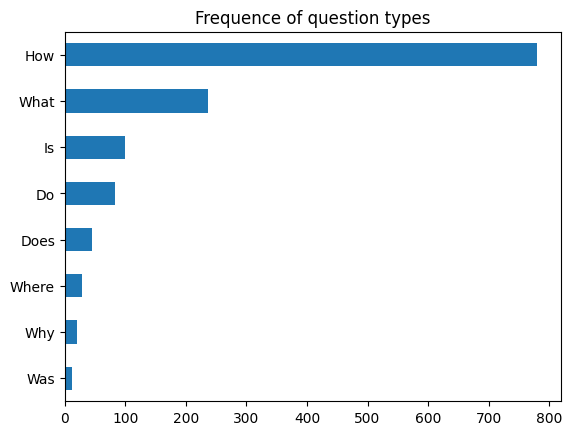

In [8]:
# let's get a feel for what types of questions are in the dataset

import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for question_type in question_types:
    counts[question_type] = dfs["train"]["question"].str.startswith(question_type).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequence of question types")
plt.show()

In [10]:
# Most start with How/What/Is, let's see some examples

for question_type in ["How", "What", "Is"]:
    for question in dfs["train"][dfs["train"].question.str.startswith(question_type)].sample(3, random_state=32)["question"]:
        print(question)

How was the system?
How is led?
How was your weight loss?
What do you think about noise?
What is the difference in image?
What size would you find good?
Is the focus ring smooth?
Is the color not really different?
Is the cover of the book stiff?


### Extracting answers from text

Firstly we need to indentify a potential answer as a span of text in a customer review.
eg. "Is it waterproof?" and we have a review "This watch is waterproof at 30m depth" it should return "waterproof at 30m".

We need to understand:
 - frame the supervised learning problem
 - tokenize and encode text for QA tasks
 - Deal with long passages and exceed a model max context size

#### Span classification

The most common way to extract answers from text is by framing the problem as a span classification task, where the start and end tokens of an answer span act as the labels that a model needs to predict. A good strategy here is to use a fine-tuned pretrained model since our dataset isn't very large (search for squad in huggingface hub).

In this notebook , we will use a fined-tuned MiniLM model since it is fast to train.

#### Tokeninzing text for QA


In [11]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer =  AutoTokenizer.from_pretrained(model_ckpt)

question = "How much music can this hold?"
context = "An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."
inputs = tokenizer(question, context, return_tensors="pt") 


In [12]:
# How is the tokenized format?
tokenizer.decode(inputs["input_ids"][0])

'[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]'

In [14]:
import torch 
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)

outputs

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)

In [15]:
# Here we can see that we get QuestionAnsweringModelOutput as the output of the QA head. 
# The QA head, corresponds to a linear layer that takes the hidden states from the encoder and computes
# the logtis for the start and end spans. This means we treat QA as a type of token classification, similar
# to named entity recognition.

start_logits, end_logits = outputs.start_logits, outputs.end_logits
print(f"Input IDs shape: {inputs.input_ids.shape}")
print(f"Start logits shape: {start_logits.shape}")
print(f"End logits shape: {end_logits.shape}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [17]:
# To get to the final answer we can compute the argmax ove the start and end token logits
# and then slive the span from the inputs

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [18]:
# In HF transformers, all of these pre/post processing steps are wrapped in a dedicated pipeline.

from transformers import pipeline

pipe = pipeline("question-answering", model=model_ckpt, tokenizer=model_ckpt)
pipe(question=question, context=context, topk=3)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/nurbot/miniconda3/envs/hf/lib/python3.11/site-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516193151474, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082945704460144,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253503918647766,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

#### Dealing with long text
Often we will face long texts that don't fit the context window (eg. MiniLM is only 512 tokens). For other tasks, like text classification, we simply truncated long texts. For QA, this is problematic, 

O